# I. prepare libary and data + Visualize data

<h2>1. import library </h2>

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

<h2>2. load data </h2>

In [2]:
df = pd.read_csv("./200kSample_tuned_and_delete_every_exception.csv")
df.head()

,Unnamed: 0,Title,comment_text,Tags
0,0,Safari only displays PHP code - Firefox asks w...,"<p>Aloha everyone,</p>\n\n<p>I have a class as...",php firefox safari
1,1,is ssl secure on both ways?,<p>I know that certificates that are sent by t...,ssl https
2,2,"<textarea/> tag ""swallows"" html",<p>This is a very strange problem I've been st...,html
3,3,align the tab control to the right,<p>is there any way that i can align the tab c...,.net winforms
4,4,What do the parentheses mean when you're decla...,<p><strong>Example 1</strong>:</p>\n\n<pre><co...,javascript


In [3]:
print("Dataframe shape : ", df.shape)

Dataframe shape :  (182990, 4)


In [4]:
# dùng (ví dụ 10000) để dùng thay vì load hết 183k mẫu
# df = df.iloc[:10000, :]

<strong> Chúng ta có 182990 mẫu dữ liệu và 4 cột để chứa các dữ liệu </strong>

<p> lấy vài mẫu ra để nhìn tạm nào! </p>

In [5]:
df.head()

,Unnamed: 0,Title,comment_text,Tags
0,0,Safari only displays PHP code - Firefox asks w...,"<p>Aloha everyone,</p>\n\n<p>I have a class as...",php firefox safari
1,1,is ssl secure on both ways?,<p>I know that certificates that are sent by t...,ssl https
2,2,"<textarea/> tag ""swallows"" html",<p>This is a very strange problem I've been st...,html
3,3,align the tab control to the right,<p>is there any way that i can align the tab c...,.net winforms
4,4,What do the parentheses mean when you're decla...,<p><strong>Example 1</strong>:</p>\n\n<pre><co...,javascript


### 3. kiểm tra Data

#### 3.1 Check các câu có title trùng nhau - có thể có hoặc không

In [6]:
#Xóa cột uname đi
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
df.head()

,Title,comment_text,Tags
0,Safari only displays PHP code - Firefox asks w...,"<p>Aloha everyone,</p>\n\n<p>I have a class as...",php firefox safari
1,is ssl secure on both ways?,<p>I know that certificates that are sent by t...,ssl https
2,"<textarea/> tag ""swallows"" html",<p>This is a very strange problem I've been st...,html
3,align the tab control to the right,<p>is there any way that i can align the tab c...,.net winforms
4,What do the parentheses mean when you're decla...,<p><strong>Example 1</strong>:</p>\n\n<pre><co...,javascript


<h4> Giữ lại duy nhất 1 hàng với 1 Title</h4>

In [8]:
duplicate_pairs = df.sort_values('Title', ascending=False).duplicated('Title')
print("Total number of duplicate questions : ", duplicate_pairs.sum())
df = df[~duplicate_pairs]
print("Dataframe shape after duplicate removal : ", df.shape)

df["tag_count"] = df["Tags"].apply(lambda x : len(x.split()))

Total number of duplicate questions :  9778
Dataframe shape after duplicate removal :  (173212, 3)


# II. Visualize data & basic analysis

<h3> 2.1. số nhãn & số lần xuất hiện </h3>

In [9]:
df["tag_count"].value_counts()

2    66361
1    64130
3    31025
4     9133
5     2563
Name: tag_count, dtype: int64

In [10]:
print( "Maximum number of tags in a question: ", df["tag_count"].max())
print( "Minimum number of tags in a question: ", df["tag_count"].min())
print( "Average number of tags in a question: ", df["tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  1.9587211047733413


Text(0, 0.5, 'Frequency')

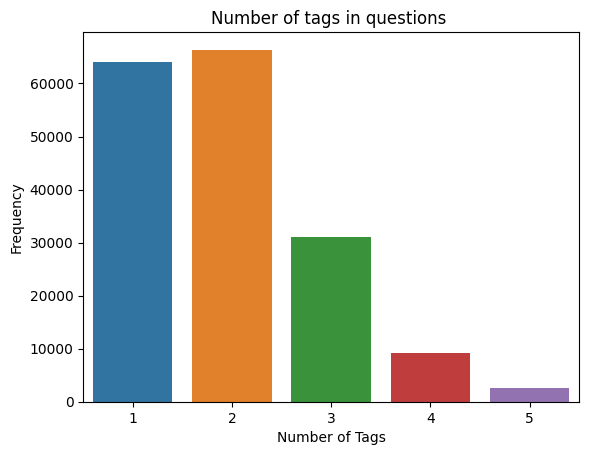

In [11]:
sns.countplot(x =df["tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

**Observations:**

1. Maximum number of tags in a question: 5
2. Minimum number of tags in a question: 1
3. Average number of tags per question: 1.95
4. Most of the questions have either 1 or 2 tags

<h3> 2.2 Tổng số lượng nhãn </h3>

<h5>tạo biến tag_bow có giá trị bằng cột tags sau khi chuyển về vectorizer để tìm cá đặc trưng của cột tags </h5>

In [12]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['Tags'])

In [13]:
print("Number of questions :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of questions : 173212
Number of unique tags : 375


<h5>Cùng check một vài nhãn </h5>

In [14]:
tags = vectorizer.get_feature_names_out()
print("Few tags :", tags[:10])

Few tags : ['.net' 'abap' 'ajax' 'algorithm' 'amazon-dynamodb' 'amazon-ec2'
 'amazon-ecs' 'amazon-s3' 'amazon-web-services' 'android']


<h3> 2.3 Tần số xuất hiện từng nhãn </h3>

In [15]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [16]:
list = []
for key, value in tag_to_count_map.items():
  list.append([key, value]) 

In [17]:
tag_df = pd.DataFrame(list, columns=['Tags', 'Counts'])
tag_df.head(20)

,Tags,Counts
0,.net,5697
1,abap,11
2,ajax,3611
3,algorithm,1200
4,amazon-dynamodb,28
5,amazon-ec2,400
6,amazon-ecs,2
7,amazon-s3,214
8,amazon-web-services,267
9,android,14691


<h4>Lập biểu đồ với trục hoành là nhãn,trục tung là tần suất xuất hiện </h4>

Text(0, 0.5, 'Frequency')

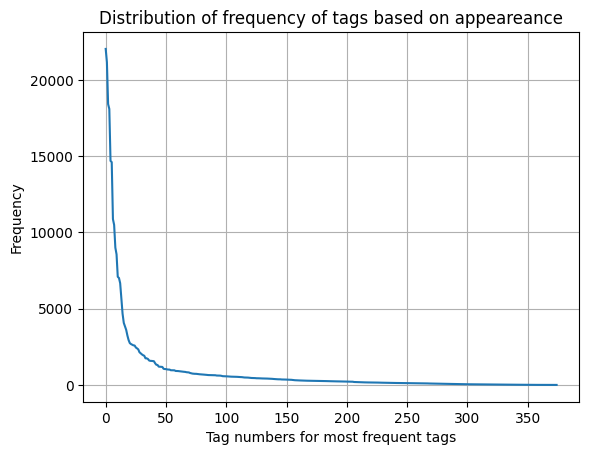

In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

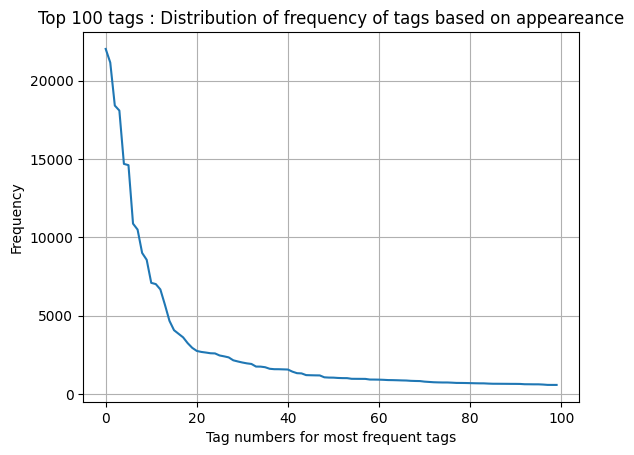

In [19]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [20]:
print("{} tags are used more than 25 times".format(tag_df_sorted[tag_df_sorted["Counts"]>25].shape[0]))
print("{} tags are used more than 50 times".format(tag_df_sorted[tag_df_sorted["Counts"]>50].shape[0]))

324 tags are used more than 25 times
297 tags are used more than 50 times


<h3> 2.4. biểu đồ tần suất cho top 20 tag </h3>

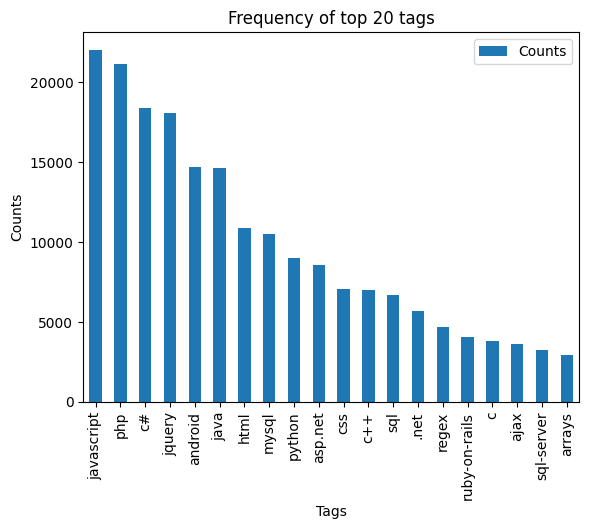

In [21]:
i=np.arange(20)
tag_df_sorted.head(20).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'].head(20))
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

**Quan sát nhận thấy:**
1. **JS#** is most frequently used tag 
2. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

### 2.5. Word map cho các từ xuất hiện thường xuyên nhất

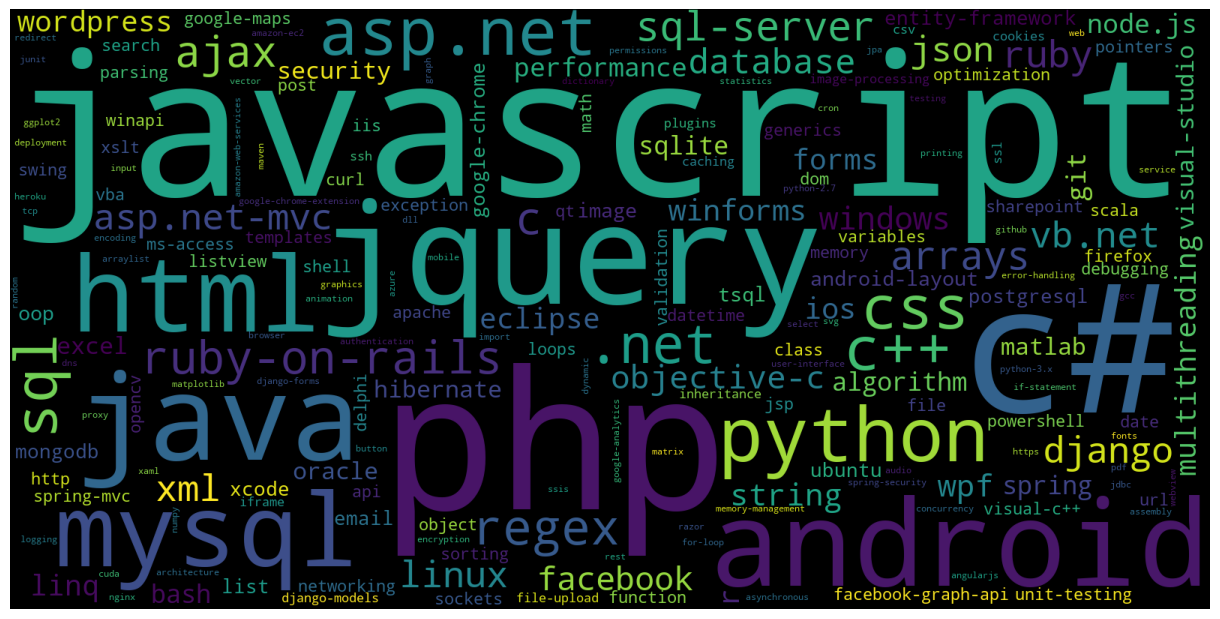

In [22]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

**Observations:**

"c#", "java", "php", "android", "javascript", "jquery", "C++" are some of the most frequent tags.

 <h1>II.Chuẩn hóa dữ liệu<h1>

<h4>2.1 import thư viện để xử lí </h4>

In [23]:
import pickle

pickle.dump(df, open("df.pkl", "wb"))

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

<h4>2.2 xóa các tag html </h4>

In [25]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


<h4>2.3 xóa các kí tự đặc biệt như "?!@#$%" </h4>

In [26]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

<h4>2.4 giữ lại các giá trị là chữ trong câu </h4>

In [27]:
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

<h4>2.5 xóa các từ xuất hiện quá nhiều lần</h4>

In [28]:
from collections import Counter
cnt = Counter()
for text in df['comment_text'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

<h4>2.6 Xóa các từ xuất hiện quá ít </h4>

In [29]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

In [30]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

<h4>2.7 xóa stopword</h4>

In [31]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

<h4>2.8 xóa khoảng trắng thừa </h4>

In [32]:

def trimWords(sentence):
    return sentence.strip()

<h4>2.9 xử lí teen code</h4>

In [33]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [34]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

<h4> 2.10 xóa urls </h4>

In [35]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

<h4>2.11 chuyển các từ về dạng chuẩn duy nhất, ex exciting hoặc excited-> excite </h4>

In [36]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

<h3> Cùng dùng các hàm trên để chuẩn hóa nào ! </h3>

In [37]:
df['comment_text'] = df['comment_text'].str.lower()

df['comment_text'] = df['comment_text'].apply(cleanHtml)

df['comment_text'] = df['comment_text'].apply(cleanPunc)

df['comment_text'] = df['comment_text'].apply(lambda text: remove_rarewords(text))

df['comment_text'] = df['comment_text'].apply(lambda text: remove_freqwords(text))

df['comment_text'] = df['comment_text'].apply(lambda text: remove_urls(text))

df['comment_text'] = df['comment_text'].apply(keepAlpha)

df['comment_text'] = df['comment_text'].apply(lambda text: trimWords(str(text)))
# data['comment_text'] = data['comment_text'].apply(lambda text: correct_spellings(str(text))) # bỏ do quá tốn thời gian chạy
df['comment_text'] = df['comment_text'].apply(lambda text: chat_words_conversion(str(text)))

df['comment_text'] = df['comment_text'].apply(stemming)

KeyboardInterrupt: 

<h1>III. Tiền xử lí dữ liệu </h1>

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

<strong> thêm 3 lần trọng số cho title + 1 lần nội dung câu hỏi để dùng làm dữ liệu train </strong>

In [ ]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["comment_text"], row["Tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(str(title)) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=str(title).encode('utf-8')
    question=str(title)+" "+str(title)+" "+str(title)+" "+ body
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
df["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df.shape[0])

Avg. length of questions(Title+Body) before preprocessing:  734.339693554719
Avg. length of questions(Title+Body) after preprocessing:  672.0046994434566
% of questions containing code:  0.0


In [ ]:
#lưu lại về sau đỡ phải chạy
# import pickle
# pickle.dump(df, open("df.pkl", 'rb'))

In [ ]:
df.head()

,Title,comment_text,Tags,tag_count,question
0,Safari only displays PHP code - Firefox asks w...,aloha everyon i have class assign which i am t...,php firefox safari,3,safari display php code firefox ask app displa...
1,is ssl secure on both ways?,i know that certif that are sent by server can...,ssl https,2,ssl secur way ssl secur way ssl secur way know...
2,"<textarea/> tag ""swallows"" html",this veri strang problem ive been struggl with...,html,1,textarea tag swallow html textarea tag swallow...
3,align the tab control to the right,there ani way that i can align tab control rig...,.net winforms,2,align tab control right align tab control righ...
4,What do the parentheses mean when you're decla...,exampl function return ok function b this c a ...,javascript,1,parenthes mean declar call properti parenthes ...


In [ ]:
preprocessed_df = df[["comment_text", "question","Tags"]]

print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (173212, 3)


<strong> Từ đây, dữ liệu ta dùng để nạp vào các bước xử lí tiếp theo là preprocessed_df</strong>

<h1> IV Feature extraction - đưa đoạn text về dạng máy tính có thể hiểu </h1>

<h3>4.1 đưa nhãn về dạng count vector ( do nó chỉ có 0 -1 nên có thể lợi dụng trong binary classification model) </h3>

In [ ]:
y_vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
y_multilabel = y_vectorizer.fit_transform(preprocessed_df['Tags'])

<h3>4.2 Giới hạn số nhãn ta dùng để train - do số nhãn là 300 nên vứt cũng được </h3>

In [ ]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

<h3>4.3 đánh giá độ phủ của số lượng tag ta chọn dựa theo hàm bên trên</h3>

In [ ]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

In [ ]:
# plt.plot(np.arange(100,total_tags, 100),questions_covered)
# plt.xlabel("Number of tags")
# plt.ylabel("Number of questions covered partially")
# plt.grid()
# plt.show()
# print(questions_covered[100],"% of questions covered by 100 tags")
# print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(100),"out of ", total_qus)

In [ ]:
yx_multilabel = tags_to_consider(300)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 375
Number of tags considered : 300 ( 80.0 %)


<h3> 4.4, chia tập train và test theo tỉ lệ 50/50 </h3>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, y_multilabel, test_size = 0.5,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 86606
Number of data points in test data : 86606


In [ ]:
'''dùng để lưu lại các dữ liệu đã qua xử lí'''
# import pickle
# pickle.dump(X_train_multilabel, open("X_train_multilabel.pkl", "wb"))
# # pickle.dump(X_test_multilabel, open("X_test_multilabel.pkl", "wb"))
# pickle.dump(y_train, open("y_train.pkl", "wb"))
# pickle.dump(y_test, open("y_test.pkl", "wb"))
# pickle.dump(X_train, open("X_train.pkl", "wb"))
# pickle.dump(X_test, open("X_test.pkl", "wb"))

'dùng để lưu lại các dữ liệu đã qua xử lí'

<h3>4.5 Chuyển câu text về dạng TF-IDF</h3>

In [ ]:
#vector gồm tối đa 20000 chiều, trong 1 câu có thể lấy 1 hoặc từ đó + từ kế tiếp làm 1 chiều của vector
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [ ]:
# dùng để lưu 
# !pip install dill

In [ ]:
#dùng để lưu vectorizer 
# import dill

# # Serialize with dill
# with open('vectorizer_180k_50.pkl', 'wb') as file:
#     dill.dump(vectorizer, file)
    
# with open('y_vectorizer_file_180k_50.pkl', 'wb') as file:
#     dill.dump(y_vectorizer, file)

In [ ]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (86606, 167713) Y : (86606, 375)
Test data shape X :  (86606, 167713) Y: (86606, 375)


<h1>V. Train model </h1>

<h3>5.1 sử dụng SVM (loss='hinge') và lasso (l2) cùng trọng số cho mỗi class là balanced</h3>

In [ ]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='hinge', penalty='l2',random_state=42, class_weight= 'balanced')

In [ ]:
clf = OneVsRestClassifier(model)
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [ ]:
# import pickle

# pickle.dump(clf, open("fileSVM50.pkl", 'wb'))
# df = pickle.load(open("df.pkl", 'rb'))

In [ ]:
# import pickle
# clf2 = pickle.load(open("fileSVM2.pkl", "rb"))

<h1>VI. đánh giá model</h1>

In [ ]:
y_pred = clf.predict(X_test_multilabel)

In [ ]:

print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))
#print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

Accuracy : 0.003267671985774658
Macro f1 score : 0.3946486978451795
Micro f1 scoore : 0.42093094623060023
Hamming loss : 0.011968808935485608


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix


# Chuyển đổi ma trận csr_matrix thành ma trận dense
y_pred_dense = y_pred.toarray()
y_test_dense = y_test.toarray()

N = np.sum(y_test_dense == 0)
# Tính true negative (TN)
TN = np.sum((y_pred_dense == 0) & (y_test_dense == 0))

# Tính false negative (FN)
FN = np.sum((y_pred_dense == 0) & (y_test_dense == 1))

TP = np.sum((y_pred_dense == 1) & (y_test_dense == 1))

# Tính false positive (FP)
FP = np.sum((y_pred_dense == 1) & (y_test_dense == 0))

P = TP/(TP + FP)
R = TP/(TP + FN)

print("Mean F1 (TNR)", 2*P*R/(P + R))

print("True Positive Rate (TPR)):", TP/(TP + FN))
print("True Negative Rate (TNR)", TN/(FP + TN))
print("False Positive Rate (FPR)", FP/(FP + TN))
print("False Negative Rate (FNR) - thà báo nhầm còn hơn bỏ sót", FN/(TP + FN))
print("Precision - do chấp nhận các dự đoán sai để tránh dự đoán thiếu", TP / (TP + FP))
print("Recall", TP / (TP + FN))


Mean F1 (TNR) 0.42093094623060023
True Positive Rate (TPR)): 0.8339629769550434
True Negative Rate (TNR) 0.9888390564742764
False Positive Rate (FPR) 0.011160943525723568
False Negative Rate (FNR) - thà báo nhầm còn hơn bỏ sót 0.16603702304495654
Precision - do chấp nhận các dự đoán sai để tránh dự đoán thiếu 0.28150940689347353
Recall 0.8339629769550434


In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred,target_names=y_vectorizer.get_feature_names_out()))

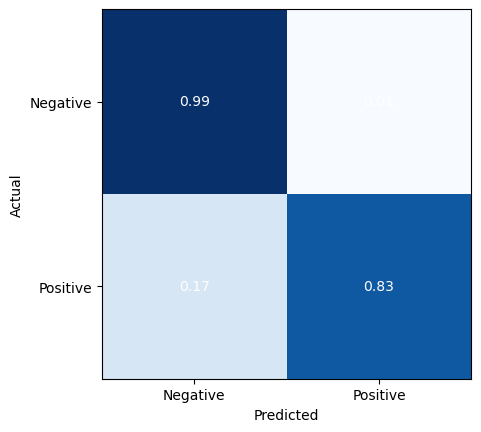

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics
TPR = TP/(TP + FN)
FPR = FP/(FP + TN)
TNR = TN/(FP + TN)
FNR = FN/(TP + FN)

# Calculate the complement of TNR to obtain FPR
FPR = 1 - TNR

# Calculate the normalized confusion matrix values
total_positive = TP + FN  # Provide the actual total number of positive instances
total_negative = FP + TN  # Provide the actual total number of negative instances

TP = TPR * total_positive
FN = FNR * total_positive
TN = TNR * total_negative
FP = FPR * total_negative

# Construct the normalized confusion matrix
confusion_matrix = np.array([[TN / total_negative, FP / total_negative], [FN / total_positive, TP / total_positive]])

# Plot the normalized confusion matrix as a heatmap
plt.imshow(confusion_matrix, cmap='Blues')

# Add labels and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])

# Add the values in each cell of the normalized confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix[i, j]:.2f}', ha='center', va='center', color='white')

# Display the normalized confusion matrix
plt.show()